# [과제 3] 로지스틱 회귀분석
### - sklearn 패키지를 사용해 로지스틱 회귀분석을 진행해주세요.
### - 성능지표를 계산하고 이에 대해 해석해주세요.
### - 성능 개선을 시도해주세요. (어떠한 성능지표를 기준으로 개선을 시도했는지, 그 이유도 함께 적어주세요.)
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

## Data 

출처 : https://www.kaggle.com/mlg-ulb/creditcardfraud


* V1 ~ V28 : 비식별화 된 개인정보 
* **Class** : Target 변수  
  - 1 : fraudulent transactions (사기)
  - 0 : otherwise 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/ToBig's/week2/assignment3_creditcard.csv")

In [4]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.848212,2.384900,0.379573,1.048381,-0.845070,2.537837,-4.542983,-10.201458,-1.504967,-2.234167,...,2.585817,-5.291690,0.859364,0.423231,-0.506985,1.020052,-0.627751,-0.017753,0.280982,0
1,2.071805,-0.477943,-1.444444,-0.548657,0.010036,-0.582242,-0.042878,-0.247160,1.171923,-0.342382,...,-0.077306,0.042858,0.390125,0.041569,0.598427,0.098803,0.979686,-0.093244,-0.065615,0
2,-2.985294,-2.747472,1.194068,-0.003036,-1.151041,-0.263559,0.553500,0.635600,0.438545,-1.806488,...,1.345776,0.373760,-0.385777,1.197596,0.407229,0.008013,0.762362,-0.299024,-0.303929,0
3,-1.479452,1.542874,0.290895,0.838142,-0.529290,-0.717661,0.484516,0.545092,-0.780767,0.324804,...,0.038397,0.116771,0.405560,-0.116453,0.541275,-0.216665,-0.415578,0.027126,-0.150347,0
4,-0.281976,-0.309699,-2.162299,-0.851514,0.106167,-1.483888,1.930994,-0.843049,-1.249272,1.079608,...,-0.875516,-0.004199,1.015108,-0.026748,0.077115,-1.468822,0.751700,0.496732,0.331001,0


In [5]:
#train 데이터와 test 데이터로 나눠준다.
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=1)

In [6]:
train.shape, test.shape

((20074, 29), (8604, 29))

가장 먼저 로지스틱 회귀만 적용한 모델을 만들어본다.

In [17]:
x_train = train.iloc[:, 0:28]
y_train = train['Class']

x_test = test.iloc[:, 0:28]
y_test = test['Class']

In [21]:
from sklearn.linear_model import LogisticRegression

# 모델 생성 및 학습
logistic = LogisticRegression()
logistic.fit(x_train, y_train)
pred = logistic.predict(x_test)

In [22]:
#결과 확인
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

val_score = f1_score(y_test, pred, average='macro') #f1 score를 기준으로 성능 향상 시도
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(y_test, pred))

Validation F1 Score : [0.8945583928038922]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8531
           1       0.91      0.70      0.79        73

    accuracy                           1.00      8604
   macro avg       0.95      0.85      0.89      8604
weighted avg       1.00      1.00      1.00      8604



### 1. 성능향상을 위해 feature들의 스케일을 동일하게 만들어주는 정규화를 진행해본다.

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_sclaed = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [28]:
# 모델 생성 및 학습
logistic.fit(x_train_sclaed, y_train)
pred_scaled = logistic.predict(x_test_scaled)

In [29]:
val_score = f1_score(y_test, pred_scaled, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(y_test, pred_scaled))

Validation F1 Score : [0.8945583928038922]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8531
           1       0.91      0.70      0.79        73

    accuracy                           1.00      8604
   macro avg       0.95      0.85      0.89      8604
weighted avg       1.00      1.00      1.00      8604



정규화 결과, 정규화는 성능향상에 큰 영향을 미치지 못한다는 사실을 알 수 있다.

### 2. 유용한 feature들만 추출하여 로지스틱 회귀를 진행해본다.


*   z-test를 이용하는 방법
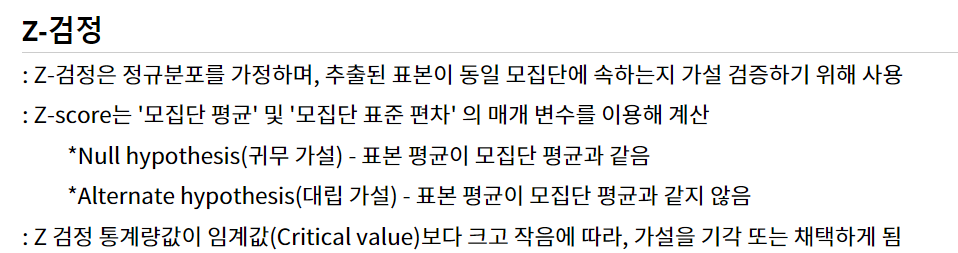


In [31]:
train_normal = train[train['Class']==0]
train_fraud = train[train['Class']==1]
cols = train_normal.columns[:-1]

In [32]:
#Z-value를 구할 수 있는 함수 ztest 작성
def ztest(feature):
  mean = train_normal[feature].mean()
  std = train_fraud[feature].std()
  ZScore = (train_fraud[feature].mean()-mean)/(std/np.sqrt(len(train_fraud)))
  return ZScore

In [33]:
significant_features = [] #유용한 feature들만 추출하기 위한 리스트 생성
critical_value = 2.58 #유의수준을 0.01로 지정

In [34]:
for i in cols:
  z_value = ztest(i)
  print(i , ':' , z_value)
  if(abs(z_value) >= critical_value):
    significant_features.append(i)

V1 : -10.187934488678518
V2 : 13.97287260864167
V3 : -14.340532890596979
V4 : 22.00967843750401
V5 : -9.412520814231396
V6 : -10.859246758640122
V7 : -11.74789001734311
V8 : 1.3815159762007367
V9 : -15.329779661899918
V10 : -17.145163680921467
V11 : 20.018349733928574
V12 : -19.473138790910195
V13 : -0.3861797360197718
V14 : -24.00326669798608
V15 : -0.8280654898113494
V16 : -16.136908766718697
V17 : -14.360922325943536
V18 : -11.910115375921979
V19 : 7.122691241784733
V20 : 4.481512570800447
V21 : 2.758455685411316
V22 : -0.2718622581398722
V23 : 1.532103099457091
V24 : -3.3914599579747455
V25 : 1.4017584308842956
V26 : 2.0400151412215624
V27 : 1.7928836704301006
V28 : 2.1274286599805134


In [36]:
print(significant_features)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24']


z검정을 통해 train data의 fraud 값이 유의미하게 다른 feature만을 뽑아낼 수 있다. 0.01의 유의수준을 잡으면 2.58의 critical value를 가지고, 이를 통해 feature를 추출하면 총 19개의 특성을 추출할 수 있다.

In [38]:
#유용한 feature들만 추출하기
train_sig = train.loc[:, ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24']]
test_sig = test.loc[:, ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24']]

In [39]:
logistic.fit(train_sig, y_train)
pred_sig = logistic.predict(test_sig)

In [40]:
val_score = f1_score(y_test, pred_sig, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(y_test, pred_sig))

Validation F1 Score : [0.9087755562080997]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8531
           1       0.96      0.71      0.82        73

    accuracy                           1.00      8604
   macro avg       0.98      0.86      0.91      8604
weighted avg       1.00      1.00      1.00      8604



적지만 성능이 향상된 것을 볼 수 있다.

### 3. 클래스 불균형 문제 해결을 위해 데이터 리샘플링


*   머신러닝 알고리즘은 일반적으로 데이터 세트에 포함된 클래스들이 거의 균등할 때 잘 작동하기 때문



In [53]:
data['Class'].value_counts() #부정거래의 수가 굉장히 적은 것을 볼 수 있다.

0    28432
1      246
Name: Class, dtype: int64

SMOTE를 이용해서 리샘플링 진행
* 소수 클래스를 오버샘플링하여 불균형 조정
* 부정거래의 가장 최근접 이웃의 특성을 사용하여 새로운 부정거래 샘플을 생성

In [74]:
from imblearn.over_sampling import BorderlineSMOTE

In [75]:
oversample = BorderlineSMOTE()
train_re_x, train_re_y = oversample.fit_resample(x_train, y_train)

In [79]:
logistic.fit(train_re_x, train_re_y)
pred_re = logistic.predict(x_test)

In [80]:
val_score = f1_score(y_test, pred_re, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(y_test, pred_re))

Validation F1 Score : [0.8658569360406845]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8531
           1       0.68      0.79      0.73        73

    accuracy                           1.00      8604
   macro avg       0.84      0.90      0.87      8604
weighted avg       1.00      1.00      1.00      8604



오히려 성능이 감소하는 것을 볼 수 있었으나, 후에 오버샘플링을 잘 적용한다면 성능을 증가시킬 수 있을 것이라 기대한다.